In [1]:
%matplotlib inline

**注意：本节将主要展示CPU与GPU训练差异以及torchvision使用，对于训练可视化以及其它部分等予以省略**

## torchvision使用

一般情况下处理图像、文本、音频和视频数据时，可以使用标准的Python包来加载数据到一个numpy数组中。
然后把这个数组转换成 ``torch.*Tensor``。

-  图像可以使用 Pillow, OpenCV
-  音频可以使用 scipy, librosa
-  文本可以使用原始Python和Cython来加载，或者使用 NLTK或
   SpaCy 处理

特别的，对于图像任务，我们创建了一个包
``torchvision``，它包含了处理一些基本图像数据集的方法。这些数据集包括
Imagenet, CIFAR10, MNIST 等。除了数据加载以外，``torchvision`` 还包含了图像转换器，
``torchvision.datasets`` 和 ``torch.utils.data.DataLoader``。

``torchvision``包不仅提供了巨大的便利，也避免了代码的重复。

在这个教程中，我们使用CIFAR10数据集，它有如下10个类别
：‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’。CIFAR-10的图像都是
3x32x32大小的，即，3颜色通道，32x32像素。

![](https://pytorch.org/tutorials/_images/cifar10.png)


依次按照下列顺序进行：

1. 使用``torchvision``加载和归一化`CIFAR10`训练集和测试集
2. 定义一个卷积神经网络
3. 定义损失函数
4. 在训练集上训练网络
5. 在测试集上测试网络

使用`torchvision`可以非常容易地加载`CIFAR10`


## 导入必要的包

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

torchvision的输出是[0,1]的PILImage图像，我们把它转换为归一化范围为[-1, 1]的张量。


## 数据获取与数据处理

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),    # 将PIL或Imagenumpy.ndarray转换为tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # 用均值和标准偏差使张量图像归一化，
                                                              # 对于每一个通道都要给定方差std以及均值mean，
                                                              # 此时transform会将输入的通道进行归一化
                                                              # (mean[1],...,mean[n])(std[1],..,std[n])ntorch.*Tensoroutput[channel] 
                                                              # = (input[channel] - mean[channel]) / std[channel]

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=False, transform=transform)

# 设置batch_size=4则会再每次迭代出4张图片
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10,
                                         shuffle=False, num_workers=2)

# 定义标签字典
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

我们展示一些训练图像。



## 部分数据展示

**torchvision.utils.make_grid将在本系列中的迁移学习进行讲解**

(3, 70, 172)
 frog   dog truck  ship


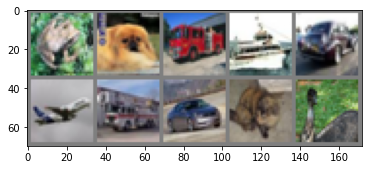

In [4]:
# 展示图像的函数
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(npimg.shape)
    
    # 将通道数移至最后，每个图像的尺寸为32x32，其中边宽为2
    # 所以维度为（32+2+2）x（32x4+10）
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# 将数据制作成迭代器，并获取随机数据
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 展示图像
imshow(torchvision.utils.make_grid(images, nrow=5))
# 显示图像标签，利用列表推断式获取4张图片的标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

安装工具`torchsummary`，可以实现和`Keras summary`几乎一样的效果，使用`!pip install torchsummary`，前面已经介绍过

## 开始训练

### CPU 训练

模型构建

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # in_channels，out_channels，kernel_size
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

利用`summary`获取每一层输出的维度

In [6]:
from torchsummary import summary

summary(net, input_size=(3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


获取每一参数优化层的维度，可以计算每一参数优化层的优化参数个数，其中包括`卷积参数`与其`对应的偏置项`

In [7]:
params = list(net.parameters())
print('optimization layers:', len(params))

for i in range(len(params)):
    print(params[i].size())
    if i % 2 == 1:
        print('INFO: layer', int((i + 1) / 2), 'Param=', 
              (np.prod(params[i-1].size()) + params[i].size())[0])

optimization layers: 10
torch.Size([6, 3, 5, 5])
torch.Size([6])
INFO: layer 1 Param= 456
torch.Size([16, 6, 5, 5])
torch.Size([16])
INFO: layer 2 Param= 2416
torch.Size([120, 400])
torch.Size([120])
INFO: layer 3 Param= 48120
torch.Size([84, 120])
torch.Size([84])
INFO: layer 4 Param= 10164
torch.Size([10, 84])
torch.Size([10])
INFO: layer 5 Param= 850


我们使用交叉熵`Cross-Entropy`作为损失函数，使用带动量的随机梯度下降`SGD`做优化器。

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

利用 `%%time` 获取 cell 每运行一次所花费的时间

In [9]:
%%time

for epoch in range(10):  # 多批次循环

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入
        inputs, labels = data

        # 梯度置0
        optimizer.zero_grad()

        # 正向传播 + 反向传播 + 优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印状态信息
        running_loss += loss.item()
        if i % 2000 == 1999:    # 每2000批次打印一次
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.250
[1,  4000] loss: 1.850
[2,  2000] loss: 1.547
[2,  4000] loss: 1.444
[3,  2000] loss: 1.340
[3,  4000] loss: 1.300
[4,  2000] loss: 1.208
[4,  4000] loss: 1.197
[5,  2000] loss: 1.108
[5,  4000] loss: 1.123
[6,  2000] loss: 1.047
[6,  4000] loss: 1.041
[7,  2000] loss: 0.985
[7,  4000] loss: 0.991
[8,  2000] loss: 0.919
[8,  4000] loss: 0.957
[9,  2000] loss: 0.890
[9,  4000] loss: 0.897
[10,  2000] loss: 0.834
[10,  4000] loss: 0.870
Finished Training
Wall time: 11min 49s


我们在整个训练集上进行了2次训练，但是我们需要检查网络是否从数据集中学习到有用的东西。
通过预测神经网络输出的类别标签与实际情况标签进行对比来进行检测。
如果预测正确，我们把该样本添加到正确预测列表。
第一步，显示测试集中的图片并熟悉图片内容。

(3, 70, 274)
GroundTruth:  cat  ship  ship  plane 


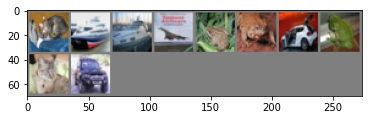

In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 显示图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%s ' % classes[labels[j]] for j in range(4)))

让我们看看神经网络认为以上图片是什么。



In [11]:
outputs = net(images)

输出是10个标签的能量。
一个类别的能量越大，神经网络越认为它是这个类别。所以让我们得到最高能量的标签。


In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s ' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  cat  ship  ship  plane 


结果看来不错。

接下来让看看网络在整个测试集上的结果如何。



In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %


### 类别准确率测试

结果看起来不错，至少比随机选择要好，随机选择的正确率为10%。
似乎网络学习到了一些东西。



在识别哪一个类的时候好，哪一个不好呢？



In [14]:
'''
设计思想：将每一类预测值与真实值进行对比，正确的为True
错误的为False，然后将所有的预测True相加，得到总的
预测正确的，最后除以总数量，得到每一类的正确率
'''

# 创建一个10维列表，存储后面每个类累计的值
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 独热码类型分布，输出为4x10的矩阵，分别表示batchsize：4以及类别：10
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        # 将输入张量形状中的 1 去除并返回，例如[1, 2, 3]
        # 返回[2, 3]，当给定 dim 时，那么挤压操作只在给定维度
        # 在这里由于返回的bool值，可以不使用.squeeze()操作
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            # 获取具体值
            class_correct[label] += c[i].item()
            # 对应类别自加
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 79 %
Accuracy of   car : 80 %
Accuracy of  bird : 46 %
Accuracy of   cat : 44 %
Accuracy of  deer : 60 %
Accuracy of   dog : 37 %
Accuracy of  frog : 78 %
Accuracy of horse : 64 %
Accuracy of  ship : 75 %
Accuracy of truck : 64 %


## GPU 训练

把一个神经网络移动到GPU上训练就像把一个Tensor转换GPU上一样简单。并且这个操作会递归遍历有所模块，并将其参数和缓冲区转换为CUDA张量。


In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 确认我们的电脑支持CUDA，然后显示CUDA信息：

print(device)

cuda:0


In [16]:
# 返回gpu数量
GPU_num = torch.cuda.device_count()
# 返回gpu名字，设备索引默认从0开始
GPU_name = torch.cuda.get_device_name(0)
# 返回当前设备索引
GPU_index = torch.cuda.current_device()
print(GPU_num, GPU_name, GPU_index)

1 GeForce GTX 960M 0


本节的其余部分假定`device`是CUDA设备。

然后这些方法将递归遍历所有模块并将模块的参数和缓冲区
转换成CUDA张量：


```python
    net.to(device)
```

记住：inputs, targets 和 images 也要转换。

```python
    inputs, labels = inputs.to(device), labels.to(device)
```

In [17]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # in_channels，out_channels，kernel_size
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
GPU_net = Net().to(device)

查看summary

In [19]:
from torchsummary import summary

summary(GPU_net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


注意将训练改为GPU时，记得重新定义优化器，损失函数只要原理没改变，可以沿用，此处我多写一遍

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(GPU_net.parameters(), lr=0.001, momentum=0.9)

In [21]:
%%time

for epoch in range(10):  # 多批次循环

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入
        inputs, labels = data
        # 转移到cuda上
        inputs, labels = inputs.to(device), labels.to(device)

        # 梯度置0
        optimizer.zero_grad()

        # 正向传播 + 反向传播 + 优化
        outputs = GPU_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印状态信息
        running_loss += loss.item()
        if i % 2000 == 1999:    # 每2000批次打印一次
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.197
[1,  4000] loss: 1.789
[2,  2000] loss: 1.514
[2,  4000] loss: 1.421
[3,  2000] loss: 1.300
[3,  4000] loss: 1.268
[4,  2000] loss: 1.184
[4,  4000] loss: 1.168
[5,  2000] loss: 1.104
[5,  4000] loss: 1.095
[6,  2000] loss: 1.036
[6,  4000] loss: 1.043
[7,  2000] loss: 0.979
[7,  4000] loss: 0.979
[8,  2000] loss: 0.932
[8,  4000] loss: 0.915
[9,  2000] loss: 0.887
[9,  4000] loss: 0.886
[10,  2000] loss: 0.840
[10,  4000] loss: 0.853
Finished Training
Wall time: 6min 22s


对比GPU与CPU的训练可以发现GPU能有效提高训练速度